In [1]:
import tensorflow as tf
import keras
import optuna
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import json
import os
import random
import logging
from sklearn.model_selection import train_test_split
from keras import layers

2024-08-19 10:13:24.532944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:13:24.539788: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:13:24.559181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 10:13:24.584878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 10:13:24.591500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 10:13:24.609282: I tensorflow/core/platform/cpu_feature_gu

In [2]:
IMG_PATH = 'img/'
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IM_SHAPE = (500,500, 1)

## Image preprocessing

In [3]:
def square_img(imPath: tf.Tensor):
    path = bytes.decode(imPath.numpy())
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    h_diff = 0 if h >= w else abs(h - w) // 2
    w_diff = 0 if w >= h else abs(h - w) // 2
    squared_img = cv2.copyMakeBorder(img, h_diff, h_diff, w_diff, w_diff, cv2.BORDER_CONSTANT, value=205)
    squared_img = squared_img / 255.
    pad = 25
    squared_img = squared_img[pad:-pad, pad:-pad]   # partially remove the gray padding
    return cv2.resize(squared_img, IM_SHAPE[:-1], interpolation=cv2.INTER_LINEAR)

# Data preprocessing

### Read csv files and create datasets

In [4]:
df = pd.read_csv('data.csv')
df['id'] = df['id'].apply(lambda id: os.path.join(IMG_PATH, id))
df

,id,traslErr,rotErr
0,img/32-G5.png,0.549900,0.049978
1,img/32-G7.png,0.655930,0.048543
2,img/32-G9.png,0.461634,0.035468
3,img/32-D8.png,0.518458,0.041766
4,img/W31-2.png,0.222666,0.017267
...,...,...,...
394,img/54-17.png,0.218436,0.009453
395,img/9-1.png,0.224472,0.013481
396,img/W59-1.png,0.488963,0.019514
397,img/E34-3.png,0.152541,0.012658


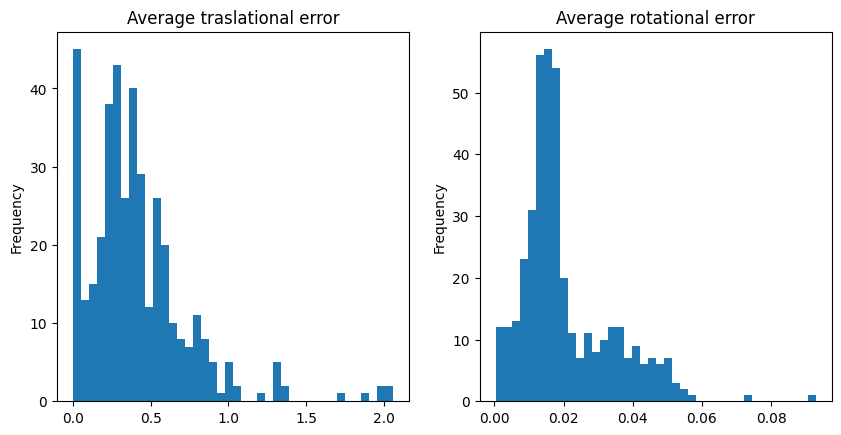

In [5]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['traslErr'].plot.hist(bins=40, title='Average traslational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

#### Data rescaling

In [6]:
rescaler_rot = sk.preprocessing.MinMaxScaler()
rescaler_trasl = sk.preprocessing.MinMaxScaler()
df['rotErr'] = rescaler_rot.fit_transform(df['rotErr'].values.reshape(-1,1)).squeeze()
df['traslErr'] = rescaler_trasl.fit_transform(df['traslErr'].values.reshape(-1,1)).squeeze()
df

,id,traslErr,rotErr
0,img/32-G5.png,0.266868,0.536063
1,img/32-G7.png,0.318330,0.520562
2,img/32-G9.png,0.224028,0.379322
3,img/32-D8.png,0.251607,0.447355
4,img/W31-2.png,0.108043,0.182710
...,...,...,...
394,img/54-17.png,0.105990,0.098301
395,img/9-1.png,0.108920,0.141812
396,img/W59-1.png,0.237292,0.206983
397,img/E34-3.png,0.074008,0.132922


##### Data partitioning and dataset creation

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [25]:
@tf.function(reduce_retracing=True)
def load_image(record: dict):
    image = tf.py_function(func=square_img, inp=[record["id"]], Tout=tf.float32)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    return image, record["values"]


def load_dataset(df: pd.DataFrame) -> tf.data.Dataset:
    X = df["id"].values
    Y = df[["traslErr", "rotErr"]].values
    dataset = tf.data.Dataset.from_tensor_slices({"id": X, "values": Y})
    dataset = dataset.shuffle(5000)
    dataset = dataset.map(load_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=False,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset

train_data = load_dataset(train_df)
val_data = load_dataset(val_df)
test_data = load_dataset(test_df)

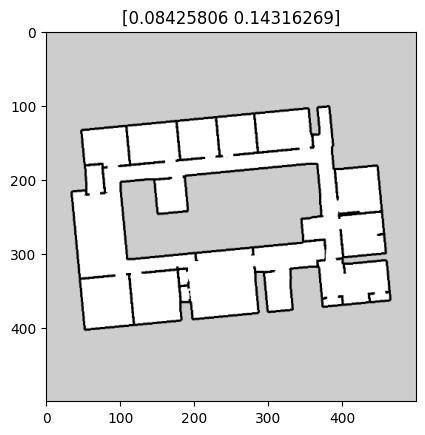

In [26]:
for b in train_data.as_numpy_iterator():
    for r in b:
        r, l = b[0], b[1]
        plt.imshow(r[0], cmap='gray')
        plt.title(l[0])
        plt.show()
        break
    break

## Define the CNN structure

In [27]:
def create_efficientNet_model(config):  # EfficientNetV2B3
    w, h = (300,300)
    resize = layers.Resizing(h, w, data_format='channels_last')
    effNet = keras.applications.EfficientNetV2B3(include_top=False, input_shape=(w, h, 3) ,pooling='avg')
    effNet.trainable = False

    input = layers.Input(shape=(500,500,1))
    x = resize(input)
    x = effNet(x)
    out = layers.Dense(2, 'sigmoid')(x)

    model = keras.Model(input, out, name='effNetSlam')

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    return model


model = create_efficientNet_model(None)

In [28]:
model.predict(test_data, batch_size=BATCH_SIZE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step


array([[0.54508996, 0.5243262 ],
       [0.54356915, 0.5224697 ],
       [0.52942705, 0.5225498 ],
       [0.5481267 , 0.524339  ],
       [0.5480106 , 0.5235658 ],
       [0.545102  , 0.525019  ],
       [0.52758706, 0.5290708 ],
       [0.53752327, 0.52308357],
       [0.5442417 , 0.5244613 ],
       [0.52599406, 0.5160372 ],
       [0.5406443 , 0.5190417 ],
       [0.54663646, 0.5238096 ],
       [0.54554826, 0.5246734 ],
       [0.54711205, 0.524616  ],
       [0.54757816, 0.524216  ],
       [0.547182  , 0.5250718 ],
       [0.54883516, 0.5245114 ],
       [0.5482816 , 0.524782  ],
       [0.54880226, 0.5239344 ],
       [0.547537  , 0.5246288 ],
       [0.54925454, 0.5245702 ],
       [0.5436268 , 0.50961053],
       [0.5469516 , 0.52344835],
       [0.5452977 , 0.52404815],
       [0.5415282 , 0.52221334],
       [0.5473437 , 0.5242936 ],
       [0.54593146, 0.52432996],
       [0.5461709 , 0.5246131 ],
       [0.54731786, 0.52505314],
       [0.54787457, 0.5240234 ],
       [0.